In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
from matplotlib import rc
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size' : 18})
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 18
    
def dround(x, dec=2):
    x += 1e-9
    return float(f'{x:.{dec}f}')

# Beirut explosion

Fit from: 
 * [Dewey, *The TNT and ANFO equivalences of the Beirut explosion* Shock Waves DOI: 10.1007/s00193-021-00992-1 (2021)](https://link.springer.com/article/10.1007%2Fs00193-021-00992-1)
 
Data from: 
 * [Rigby et al. *Preliminary yield estimation of the 2020 Beirut explosion using video footage from social media.* Shock Waves 30, 671–675 (2020)](https://link.springer.com/article/10.1007%2Fs00193-020-00970-z)
 * [Diaz *Explosion analysis from images: Trinity and Beirut* 2021 Eur. J. Phys. DOI: 10.1088/1361-6404/abe131 (2021)](https://iopscience.iop.org/article/10.1088/1361-6404/abe131)

In [3]:
tnt2j = 4.294  # 4.294 MJ/kg
kg2j = tnt2j*1e6
kt2j = kg2j*1e6
ton2j = kg2j*1e3

P0 = 0.1e6  # atmospheric pressure
rho0 = 1.23  # air density
a0 = np.sqrt(1.4 * P0 / rho0)  # speed of sound

# Beirut explosion
data_source = ['Diaz', 'Rigby et al.']
df_beirut = pd.DataFrame()
dfs = []
for name in data_source:
    df_tmp = pd.read_excel('data/Beirut_Explosion.xlsx', sheet_name=name, usecols='A:D')
    e0 = df_tmp['Yield (kt)'][0]*kt2j
    df_tmp['Source']   = [name]*len(df_tmp)
    df_tmp['Test']     = ['Beirut']*len(df_tmp)
    df_tmp['Yield']    = [df_tmp['Yield (kt)'][0]]*len(df_tmp)
    del df_tmp['Yield (kt)']
    df_beirut = pd.concat([df_beirut, df_tmp], axis=0, ignore_index=True)
    dfs.append(df_tmp)

In [4]:
dfs[1].head()

,R (m),t (s),Feature,Source,Test,Yield
0,563,1.167,Audio,Rigby et al.,Beirut,0.5
1,566,1.068,Audio,Rigby et al.,Beirut,0.5
2,572,1.068,Audio,Rigby et al.,Beirut,0.5
3,630,1.277,Audio,Rigby et al.,Beirut,0.5
4,675,1.667,Audio,Rigby et al.,Beirut,0.5


In [5]:
# R vs t from Dewey Eq (1)
def R_dewey(t):
    A, B, C = -13.5289, 53.1742, -58.3335
    return A + a0*t + B * np.log(1 + a0*t) + C * np.sqrt(np.log(1 + a0*t))

# R vs t from STvN
def R_STvN(t):
    # E0 = 1 kt
    return 1.033 * (1*kt2j/rho0)**(1/5) * t**(2/5) 

c:\users\jsdiaz\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


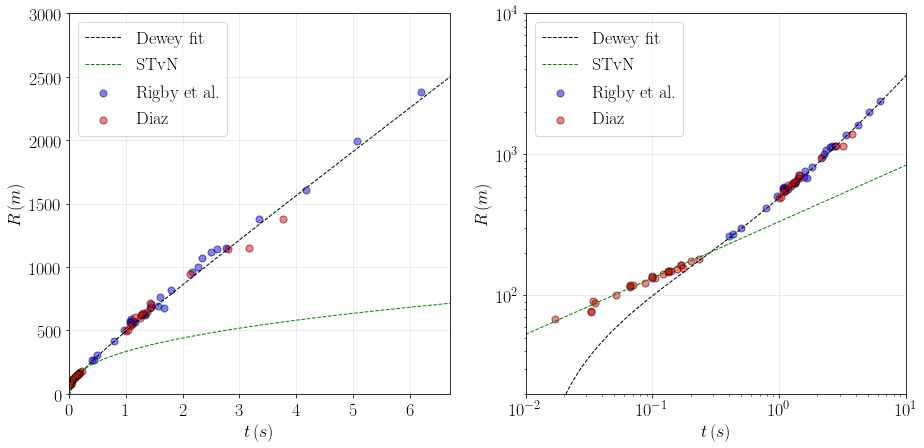

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
xmin, xmax = 0, 6.7
ymin, ymax = 0, 3000

t_axis = np.linspace(0, 7, 100)
logt   = np.logspace(-2, 4, 100)

for idx, ax in enumerate(axs.flat):
    ax.scatter(dfs[1]['t (s)'], dfs[1]['R (m)'], s=50, marker='o', color='b', edgecolor='k', alpha=.5, label='Rigby et al.')
    ax.scatter(dfs[0]['t (s)'], dfs[0]['R (m)'], s=50, marker='o', color='r', edgecolor='k', alpha=.5, label='Diaz')
    
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
           xlabel=r'$t\,(s)$', ylabel=r'$R\,(m)$')
    if idx == 1:
        xmin, xmax = 1e-2, 1e1
        ymin, ymax = 2e1, 1e4
        t_axis   = np.logspace(np.log10(xmin), np.log10(xmax), 100)
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
               xscale='log', yscale='log')
    
    ax.plot(t_axis, R_dewey(t_axis), 'k--', linewidth=1, label='Dewey fit')
    ax.plot(t_axis, R_STvN(t_axis), 'g--', linewidth=1, label='STvN')
    ax.grid(zorder=-1, alpha=.5, linewidth=0.5)
    ax.legend(loc='upper left');
# fig.savefig('plots/Dewey-paper.pdf', bbox_inches='tight')

In [7]:
# Mach number vs. t from Dewey Eq (2)
def Ms(t):
    A, B, C = -13.5289, 53.1742, -58.3335
    return 1 + B /(1 + a0*t) + C / (2*(1 + a0*t)*np.sqrt(np.log(1 + a0*t)))

# Peak hydrostatic pressure from Dewey Eq (3)
def OP(t):
    return 7/6 * (Ms(t)**2 - 1)

In [19]:
K0, K1, K2 = 7.94, 2.53, 0#0.96, 1.70
alpha = 1/K0
beta  = 1/K0 *(4*np.pi/(3*0.4) - K1)
print(f'alpha={dround(alpha)}, beta={dround(beta)}')

# def Ms_jsd(R):
#     E0 = 1*kt2j
#     z = R/(E0/P0)**(1/3)
#     return np.sqrt(beta + alpha/z**3)

def OP_jsd(R, E0=1):
    z = R/(E0*kt2j/P0)**(1/3)
    return 7/6 * alpha/z**3

alpha=0.13, beta=1.0


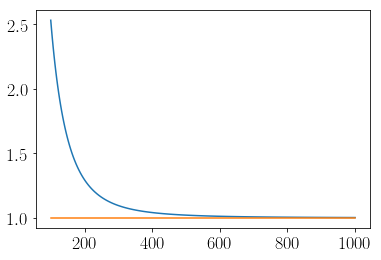

In [9]:
R_axis = np.logspace(2, 3, 100)
plt.plot(R_axis, Ms_jsd(R_axis))
plt.plot(R_axis, np.ones_like(R_axis));

In [10]:
4*np.pi/(3*0.4), np.sqrt(K0+K1+K2), K0+K1+K2

(10.471975511965976, 3.2357379374726873, 10.47)

c:\users\jsdiaz\anaconda3\lib\site-packages\matplotlib\artist.py:913: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  return func(v)


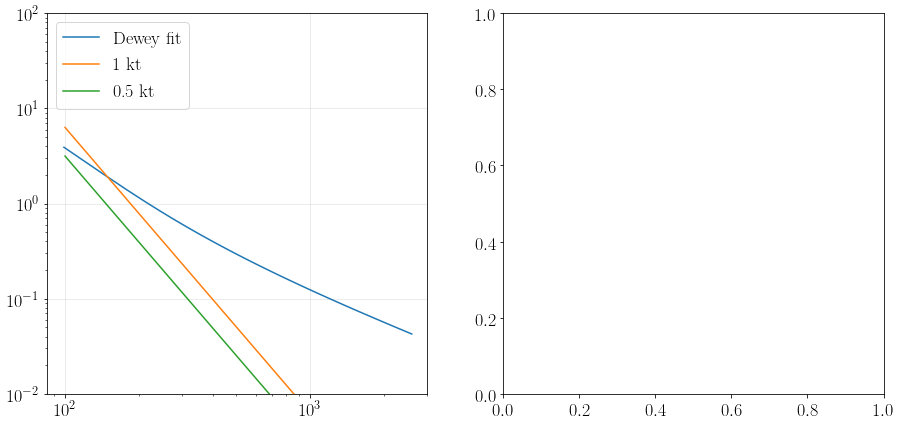

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 7))

xmin, xmax = 0, 3000
ymin, ymax = 0.01, 100

t_axis = np.linspace(0.1, 7, 100)
R_axis = np.logspace(2, 3, 100)


axs[0].plot(R_dewey(t_axis), OP(t_axis), label='Dewey fit')
axs[0].plot(R_axis, OP_jsd(R_axis, E0=1), label='1 kt')
axs[0].plot(R_axis, OP_jsd(R_axis, E0=0.5), label='0.5 kt')
axs[0].set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
           xscale='log', yscale='log')
# for idx, ax in enumerate(axs.flat):
#     ax.scatter(dfs[1]['t (s)'], dfs[1]['R (m)'], s=50, marker='o', color='b', edgecolor='k', alpha=.5, label='Rigby et al.')
#     ax.scatter(dfs[0]['t (s)'], dfs[0]['R (m)'], s=50, marker='o', color='r', edgecolor='k', alpha=.5, label='Diaz')
    
#     ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
#            xlabel=r'$t\,(s)$', ylabel=r'$R\,(m)$')
#     if idx == 1:
#         xmin, xmax = 1e-2, 1e1
#         ymin, ymax = 2e1, 1e4
#         t_axis   = np.logspace(np.log10(xmin), np.log10(xmax), 100)
#         ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], 
#                xscale='log', yscale='log')
    
#     ax.plot(t_axis, R_T(t_axis), 'k--', linewidth=1, label='Dewey fit')
#     ax.plot(t_axis, R_STvN(t_axis), 'g--', linewidth=1, label='STvN')
axs[0].grid(zorder=-1, alpha=.5, linewidth=0.5)
axs[0].legend(loc='upper left');
# fig.savefig('plots/Dewey-paper.pdf', bbox_inches='tight')